In [1]:
# Standard libraries
import numpy as np
import h5py
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
libpath = os.path.join(path1p, "lib")
pwd_mat = os.path.join(os.path.join(path2p, "data/"), "sim_ds_mat")
pwd_h5 = os.path.join(os.path.join(path2p, "data/"), "sim_ds_h5")

sys.path.insert(0, libpath)
print("Appended library directory", libpath)

# User libraries
from signal_lib import resample
from corr_lib import sprMat, corr3D
from analysis.metrics_network import diagDom
from qt_wrapper import gui_fnames, gui_fpath

from matlab.h5data_lib import readTE_H5, getStatistics, parseTEfolders, getTitlesAndIndices
from matlab.matlab_yaro_lib import read_neuro_perf, read_paw, read_lick, read_whisk
from matlab.parse_folders import parseFoldersMulti
from matlab.preprocess_behaviour import resample_lick, resample_paw, resample_whisk

Appended library directory /home/alyosha/work/git/nest-mesoscopic-metric-test/codes/lib


In [2]:
%load_ext autoreload
%autoreload 2

from matlab.parse_folders import parseFoldersMulti

# Automatically find subfolders for data and behaviour

In [3]:
tmp_path = root_path_data if 'root_path_data' in locals() else "./"
root_path_data  = gui_fpath("Path to data collection", tmp_path)
root_path_paw   = gui_fpath("Path to Paw data",        root_path_data)
root_path_lick  = gui_fpath("Path to Lick data",       root_path_paw)
root_path_whisk = gui_fpath("Path to Whisk Data",      root_path_lick)

In [4]:
pathDataSets, summary = parseFoldersMulti(root_path_data, root_path_paw, root_path_lick, root_path_whisk)

print("Number of day folders for each mouse")
pd.DataFrame(summary)

Number of day folders for each mouse


,Data,Paw,Lick,Whisk
mtp_1,9,0,11,11
mtp_11,12,6,15,11
mtp_16,13,0,13,14
mtp_12,24,30,20,17
mtp_13,12,8,13,10
mtp_7,18,4,23,24
mtp_15,13,0,13,14
mtp_2,8,0,8,10
mtp_10,8,11,10,8


# Read available data and behaviour, resample

In [5]:
def findPathIdx(typeKey, mouseDayKey):
    rez = np.where((micePathArr[:, 1] == typeKey)&(micePathArr[:, 3] == mouseDayKey))[0]
    if len(rez)==0:
        return None
    elif len(rez)==1:
        return rez[0]
    else:
        raise ValueError("Expected 0 or 1 results, got", len(rez))
        
def findDataIdx(pathIdx):
    return np.where(miceDataIdxs == pathIdx)[0][0]

def pd_filter(data, k, v):
    return data[data[k] == v]

In [8]:
# Read Neuronal data
dataNeuronal = []
dataTrials   = []
N_DATA_FILES = pathDataSets['data_path'].shape[0]
progBar = IntProgress(min=0, max=N_DATA_FILES, description='Read Neuro Data:')
display(progBar) # display the bar
for datapath in pathDataSets['data_path']['path']:
    data, behaviour = read_neuro_perf(datapath, verbose=False)
    dataNeuronal += [data]
    dataTrials   += [behaviour]
    progBar.value += 1
    
# Define resampling frequency
TARGET_RANGE = [0, 8] # Seconds goal
TARGET_FREQ = 20 # Hz
TARGET_NTIMES = int((TARGET_RANGE[1]-TARGET_RANGE[0])*TARGET_FREQ) + 1
TARGET_TIMES = np.linspace(TARGET_RANGE[0], TARGET_RANGE[1], TARGET_NTIMES)
print("Target trial within", TARGET_RANGE, "sec. Total target timesteps", TARGET_NTIMES)
    
# # Read and resample paw
# N_PAW_FILES = pathDataSets['paw_path'].shape[0]
# dataPawResampled = []
# progBar = IntProgress(min=0, max=N_PAW_FILES, description='Read paw data:')
# display(progBar) # display the bar
# for pawpath in pathDataSets['paw_path']['path']:
#     dataPaw = read_paw(pawpath, verbose=False)
#     dataPawResampled += [resample_paw(dataPaw, TARGET_TIMES, TARGET_FREQ)]
#     progBar.value += 1

# # Read and resample lick
# N_LICK_FILES = pathDataSets['lick_path'].shape[0]
# dataLickResampled = []
# progBar = IntProgress(min=0, max=N_LICK_FILES, description='Read lick data:')
# display(progBar) # display the bar

# for index, row in pathDataSets['lick_path'].iterrows():
#     # Find behaviour associated with this lick
#     dataIdxs = pd_filter(pathDataSets['data_path'], 'mousekey', row['mousekey']).index
#     if dataIdxs.shape[0] == 0:
#         dataLickResampled += [None]
#     else:
#         dataIdx = dataIdxs[0]
#         neuro = dataNeuronal[dataIdx]
#         behaviour = dataTrials[dataIdx]
#         dataLick = read_lick(row['path'], verbose=False)
#         dataLickResampled += [resample_lick(dataLick, neuro, behaviour, TARGET_TIMES, TARGET_FREQ)]
#     progBar.value += 1

# # Read and resample whisk
# N_WHISK_FILES = pathDataSets['whisk_path'].shape[0]
# progBar = IntProgress(min=0, max=N_WHISK_FILES, description='Read whisk data:')
# display(progBar) # display the bar
# dataWhiskResampled = []
# for whiskpath in pathDataSets['whisk_path']['path']:
#     dataWhisk = read_whisk(whiskpath, verbose=False)
#     dataWhiskResampled += [resample_whisk(dataWhisk, TARGET_TIMES)]
#     progBar.value += 1

IntProgress(value=0, description='Read Neuro Data:', max=117)

Behaviour has more trials than data 438 437
Behaviour max index must be less than number of trials 437 437
Target trial within [0, 8] sec. Total target timesteps 161


# Analysis

## 1. Correlation and Synchrony

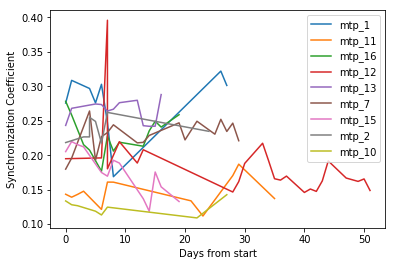

In [55]:
mice = list(set(pathDataSets['channel_labels']['mousename']))
dateDiff = lambda l: [(v - l.iloc[0]).days for v in l]

plt.figure()

for mousename in mice:
    mouseData = pd_filter(pathDataSets['data_path'], 'mousename', mousename)
    if mouseData.shape[0] > 0:
    
        deltaDays = dateDiff(mouseData["date"])
        dataIdxs = list(mouseData["date"].index)
        synchr = [diagDom(corr3D(dataNeuronal[dataIdx])) for dataIdx in dataIdxs]
            
        plt.plot(deltaDays, synchr, label=mousename)

plt.xlabel("Days from start")
plt.ylabel("Synchronization Coefficient")
plt.legend()
plt.show()